# Prey Notebook

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import multimodal_mazes

In [2]:
actions = {
    0: {'name':'Up', 'label':'↑', 'delta':(-1,0), 'angle': float(np.pi)},
    1: {'name':'Right', 'label':'→', 'delta':(0,1), 'angle': float(3 * np.pi / 2)},
    2: {'name':'Down', 'label':'↓', 'delta':(1,0), 'angle': float(0.0)},
    3: {'name':'Left', 'label':'←', 'delta':(0,-1), 'angle': float(np.pi / 2)},
}

## Agent Hyperparameters

In [27]:
width=21
height=21
pk = 30
n_prey = 1
n_steps = 100
n_trials = 100
visible_steps = n_steps
n_features = 6
cost_per_step = -10
cost_per_collision = -10
alpha = 0.2
epsilon = 0.2
gamma = 0.9

scenario =  "Static"
motion = "Linear"
multisensory = "Unisensory"

if scenario == "Static":
    pc = 0.0
    pm = 0
    pe = 1
    noise = 0
    case = None
    motion = None
elif scenario == "Constant":
    pc = 0.0
    pm = 1
    pe = 0.998
    noise = 0.002
    case = "2"
elif scenario == "Random":
    pc = 0.0
    pm = 1
    pe = 0.2
    motion = "Levy"
    case = "1"
elif scenario == "Two Prey":
    pc = 0.0
    pm = 0
    pe = 0.998
    noise = 0.002
    multisensory = "Balanced"
    case = "4"
    n_prey = 2

## Training Test

In [87]:
agnt = multimodal_mazes.QLearnerAgent(pk_hw=(pk//2), location=None, channels=[1,1], actions=actions, sensor_noise_scale=noise, n_steps=n_steps, n_features=n_features, cost_per_step=cost_per_step, cost_per_collision=cost_per_collision, alpha=alpha, gamma=gamma, epsilon=epsilon)
training_evaluator = multimodal_mazes.LinearPreyEvaluator(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe)
training_evaluator.train_RL()

100%|██████████| 5/5 [00:00<00:00, 107.97it/s]


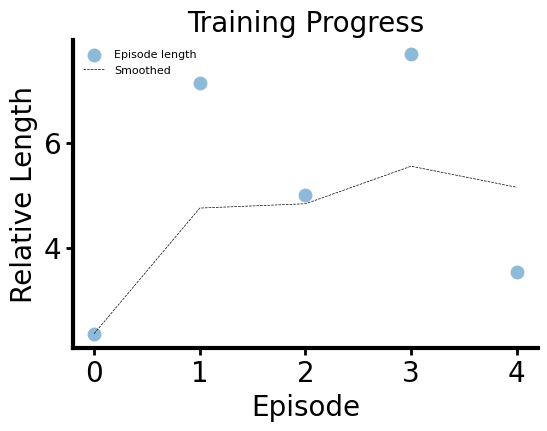

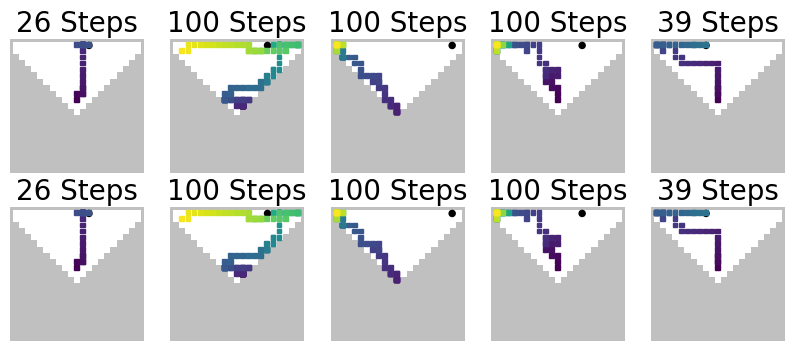

In [88]:
training_evaluator.training_plots()

In [122]:
training_evaluator.training_trial.env[15, 25]

(51, 51, 3)

In [117]:
training_evaluator.training_trial.env_log[1][15, 25]

array([0.91367735, 0.        , 1.        ])

In [116]:
training_evaluator.training_trials[4]['env'][1][:, :, :][15, 25]

array([0.91367735, 0.        , 1.        ])

## Visualisation

In [ ]:
agnt = multimodal_mazes.QLearnerAgent(pk_hw=(pk//2), location=None, channels=[1,1], actions=actions, sensor_noise_scale=noise, n_steps=n_steps, n_features=n_features, cost_per_step=cost_per_step, cost_per_collision=cost_per_collision, alpha=alpha, gamma=gamma, epsilon=epsilon)
trial = multimodal_mazes.PredatorTrial(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe, log_env=True)
time, path, preys, env_log = trial.run_trial()

In [ ]:
import matplotlib.animation as animation
from matplotlib import colors
import matplotlib.cm as cm

prey_markers = ['P', 'X']
cmap_wall = cm.binary
cmap_wall.set_under('k', alpha=0)
cmap_ch0 = colors.LinearSegmentedColormap.from_list("", ["white", "xkcd:ultramarine"])
cmap_ch1 = colors.LinearSegmentedColormap.from_list("", ["white", "xkcd:magenta"])

fig, ax = plt.subplots()

plt.imshow((cmap_ch0(env_log[1][:,:,0]) + cmap_ch1(env_log[1][:,:,1]))/2, interpolation='gaussian', zorder=0) 
plt.imshow(1 - env_log[0][:, :, -1], clim=[0.1,1.0], cmap=cmap_wall, alpha=0.25, zorder=1)
plt.xlim([(pk//2) - 1, width + pk//2])
plt.ylim([height + pk//2, (pk//2) - 1]) 
plt.axis("off")

agnt_animation = ax.scatter([], [], s=120, color='k', zorder=3)
preys_animation = [[] for _ in preys]
for a, prey in enumerate(preys): 
    if scenario == "Static":
     preys_animation[a] = ax.scatter([], [], s=60, color='k', alpha=0.5, marker=prey_markers[prey.cues], zorder=2)
    elif scenario != "Static": 
        preys_animation[a] = ax.scatter([], [], s=60, color='k', alpha=0.5, marker=prey_markers[0], zorder=2)

def update_animation(t):
    plt.imshow((cmap_ch0(env_log[t][:,:,0]) + cmap_ch1(env_log[t][:,:,1]))/2, interpolation='gaussian', zorder=0) 
    agnt_animation.set_offsets([path[t, 1], path[t, 0]])

    for a, prey in enumerate(preys): 
        try:
            preys_animation[a].set_offsets([prey.path[t][1], prey.path[t][0]])
        except:
            preys_animation[a].set(alpha=0)

#anim = animation.FuncAnimation(fig, update_animation, frames=range(0, len(path)), blit=False)
anim = animation.FuncAnimation(fig, update_animation, frames=range(0, 10), blit=False)
anim.save("Trial.gif", dpi=300)

## Percentage Capture vs Speed

In [ ]:
cases = ["1", "2", "3"]
speeds = np.linspace(start=0.0, stop=1.0, num=10)
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(speeds), len(policies)))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{motion}, {multisensory} - Percentage Captured vs Speed")


# Test agents
for case in range(len(cases)):
    for a, speed in enumerate(speeds):
        for b, policy in enumerate(policies): 
            if policy in multimodal_mazes.AgentRuleBased.policies:
                agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
            elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
                agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
                agnt.alpha = 0.6
                
            elif policy == "Levy":
                agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

            _, _, _, _, captured, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=cases[case], motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=speeds[a], pe=pe)
            results[a, b] = captured
    

    for b, policy in enumerate(policies): 
        axs[case].plot(speeds, results[:,b], color=colors[b])    
        axs[case].set_title(f"Case {case+1}")

axs[0].set(xlabel='Speed', ylabel='Percentage Captured')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));
fig.legend(loc='center right', bbox_to_anchor=(1.05, 0.5), labels=policies)

In [ ]:
cases = ["1", "2", "3"]
speeds = np.linspace(start=0.0, stop=1.0, num=10)
repeats = [i for i in range(4)]
n_trials = 10
pe = 0.998
noise = 0.002
policy = multimodal_mazes.AgentRuleBased.policies[7]
agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
# policy = multimodal_mazes.AgentRuleBasedMemory.policies[0]
# agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
results = np.zeros((len(speeds), len(repeats)))

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{multisensory} {policy} Percentage Captured vs Speed")

for case in range(len(cases)):
    capture_results = np.zeros((2, len(speeds)))
    for a, speed in enumerate(speeds):
        
        for b in repeats:
            captured = 0
            _, _, _, _, captured, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=cases[case], motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=speeds[a], pe=pe)
            results[a, b] = captured
        capture_results[0, a] = np.mean(results[a,:])
        capture_results[1, a] = np.std(results[a,:])
    
    for b in repeats:
        axs[case].plot(speeds, results[:,b], color = colors[case], alpha = 0.2)
        axs[case].set_title(f"Case {case+1}")
        axs[case].plot(speeds, capture_results[0, :], color=colors[case])
        axs[3].plot(speeds, capture_results[0, :], color=colors[case])
        axs[case].errorbar(speeds, capture_results[0, :], yerr=capture_results[1, :], color=colors[case])
        axs[3].errorbar(speeds, capture_results[0, :], yerr=capture_results[1, :], color=colors[case])

axs[0].set(xlabel='Speed', ylabel='Percentage Captured')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));

## Disappearing Percentage Captured vs Speed

In [ ]:
speeds = np.linspace(start=0.0, stop=1.0, num=10)
visible_periods = [6, 5, 4, 3, 2, 1, 0]
visible_periods_str = ['1', '2', '5', '10', '20', '50', '100']
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(speeds), len(policies)))
aucs = np.zeros((len(visible_periods), len(policies)))

fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])

# Test agents
for c, period in enumerate(visible_periods):
    actual_period = int(visible_periods_str[period])
    for a, speed in enumerate(speeds):
        for b, policy in enumerate(policies): 
            if policy in multimodal_mazes.AgentRuleBased.policies:
                agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
            elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
                agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
                agnt.alpha = 0.6
            elif policy == "Levy":
                agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

            _, _, _, _, captured = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=actual_period, multisensory=multisensory, pc=pc, pm=speed, pe=pe)
            results[a, b] = captured
    
    idy = 0
    idx = c 
    auc = np.trapz(y=results.T, x=speeds, axis=1)
    aucs[c] = auc
    
    if c >= 4:
        idy = 1
        idx = c - 4

    for b, policy in enumerate(policies): 
        axs[idy][idx].plot(speeds, results[:,b], color=colors[b])    
        axs[idy][idx].set_title(f"Time to Disappear {actual_period}")  
    
axs[0][0].set(xlabel='Speed', ylabel='Percentage Captured')
axs[0][0].set_xticks(np.arange(0.0, 1.1, 0.2));
fig.subplots_adjust(0, 0.05, 1, 0.95)
fig.legend(loc='center right', bbox_to_anchor=(1.15, 0.5), labels=policies)


In [ ]:
for b, policy in enumerate(policies): 
    plt.plot(visible_periods, aucs[:,b], color=colors[b], label=policy)

plt.xticks(range(7), visible_periods_str);
plt.xlim(6, 0)

## Disappearing Percentage Capture vs Visible Time

In [ ]:
speeds = [0, 0.25, 0.5, 0.75]
repeats = [i for i in range(4)]
cases = ["1", "2", "3"]
visible_periods = [3, 2, 1, 0]
visible_periods_str = ['1', '10', '15', '25']
n_trials = 10
# policy = multimodal_mazes.AgentRuleBased.policies[7]
# agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
policy = multimodal_mazes.AgentRuleBasedMemory.policies[1]
agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
results = np.zeros((len(visible_periods), len(repeats)))

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])

# Test agents
case_results = np.zeros((len(speeds), len(cases), len(visible_periods)))
for d, speed in enumerate(speeds):
    for a, case in enumerate(cases):
        capture_results = np.zeros((2, len(visible_periods)))

        for b, period in enumerate(visible_periods):
            actual_period = int(visible_periods_str[period])
            
            for c in repeats:
                _, _, _, _, captured, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=actual_period, multisensory=multisensory, pc=pc, pm=speed, pe=pe)
                results[b, c] = captured
                
            capture_results[0, b] = np.mean(results[b,:])
            capture_results[1, b] = np.std(results[b,:])
            
        case_results[d, a] = capture_results[0]

        for c in repeats:
            axs[d].plot(visible_periods, results[:,c], color=colors[a], alpha=0.2)    
            axs[d].set_title(f"Speed {speed}")  

        axs[d].errorbar(visible_periods, capture_results[0, :], yerr=capture_results[1, :], color=colors[a])

averaged_case_results = np.mean(case_results, axis=0)
        
axs[0].set(xlabel='Time to Disapepar', ylabel='Percentage Captured')
axs[0].set_xticks(range(4), visible_periods_str);
fig.suptitle(f"{multisensory} {policy} Percentage Captured vs Time to Disappear")  

In [ ]:
for a, case in enumerate(averaged_case_results):
    plt.plot(visible_periods, case, color=colors[a])

plt.xlim(3, 0)
plt.xticks(range(4), visible_periods_str);
plt.title('Percentage Captured vs Time to Disappear')
plt.xlabel('Time to Disappear')
plt.ylabel('Percentage Captured')

## Two Prey Capture Probabilty

In [ ]:
noises = np.linspace(start=0.0, stop=1.0, num=10)
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(noises), len(policies)))

for a, noise in enumerate(noises):
    for b, policy in enumerate(policies): 
        if policy in multimodal_mazes.AgentRuleBased.policies:
            agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
        elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
            agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
            agnt.alpha = 0.6
        elif policy == "Levy":
            agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

        _, _, _, preys, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, visible_steps=visible_steps, multisensory=multisensory, motion=motion, pc=pc, pm=pm, pe=pe)
        
        ms_captured = 0

        for prey in preys:
            if prey[0].state == 0:
                ms_captured += 1
        ms_captured = (ms_captured / n_trials)
        results[a, b] = ms_captured

plt.figure(figsize=(10, 10))
for b, policy in enumerate(policies): 
    plt.plot(noises, results[:,b], color=colors[b], label=policy)
plt.ylabel('Probability of Multisensory Prey Caught First')
plt.xlabel('Noise')
plt.yticks(np.arange(0.0, 1.1, 0.1));

In [ ]:
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(policies)))

for b, policy in enumerate(policies): 
    if policy in multimodal_mazes.AgentRuleBased.policies:
        agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
    elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
        agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
        agnt.alpha = 0.6
    elif policy == "Levy":
        agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

    _, _, _, preys, _, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, visible_steps=visible_steps, multisensory=multisensory, motion=motion, pc=pc, pm=pm, pe=pe)
    
    ms_captured = 0

    for prey in preys:
        if prey[0].state == 0:
            ms_captured += 1
    ms_captured = (ms_captured / n_trials)
    results[b] = ms_captured

plt.figure(figsize=(10, 10))
for b, policy in enumerate(policies):
    plt.scatter(policy, results[b], color=colors[b])
    ml, sl, _ = plt.stem(b, results[b])
    ml.set_color(colors[b])
    sl.set_color(colors[b])
plt.ylabel('Probability of Multisensory Prey Caught First')
plt.xlabel('Policy')
plt.xticks(range(len(policies)), policies, rotation='vertical');
plt.yticks(np.arange(0.0, 1.1, 0.1));